# DengAI Analysis Part 06a - Time Series Analysis 

By: Chengyi (Jeff) Chen, under guidance of CSCI499: AI for Social Good Teaching Assistant - Aaron Ferber

---
## Content

In this notebook, we will explore a SARIMAX analysis of the dataset for prediction.

<a id="imports"></a>

---
## Library Imports

In [1]:
# Library Imports
import sys
import pandas as pd
import numpy as np
import subprocess
import statsmodels.api as sm
from scipy import stats
import os
from collections import Counter
from sklearn import model_selection, kernel_ridge, linear_model, metrics, feature_selection, preprocessing
from os import listdir
from os.path import isfile, join, isdir
from  tqdm import  tqdm
import warnings
warnings.filterwarnings('ignore')

# plotting libraries
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-paper')
import seaborn as sns
sns.set(style="ticks")
from pylab import rcParams
%matplotlib inline

In [2]:
# DengAI dataset URLs
dengai_features_url = 'https://www.dropbox.com/s/1kuf94b4mk6axyy/dengue_features_train.csv'
dengai_labels_url = 'https://www.dropbox.com/s/626ak8397abonv4/dengue_labels_train.csv'
dengai_test_features_url = 'https://s3.amazonaws.com:443/drivendata/data/44/public/dengue_features_test.csv'

In [3]:
# Helper function to create a new folder
def mkdir(path):
    try: 
        os.makedirs(path)
    except OSError:
        if not os.path.isdir(path):
            raise
        else:
            print("(%s) already exists" % (path))

<a id="clean_feats"></a>

---
## Cleaned Features

In [4]:
sj_X = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col='week_start_date')
sj_y = pd.read_csv('./data/dengai/cleaned/sj_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')
iq_X = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col='week_start_date')
iq_y = pd.read_csv('./data/dengai/cleaned/iq_y.csv', header=None, names=['week_start_date', 'num_cases'], index_col='week_start_date')

---

<a id="ets"></a>

## Error Trend Seasonality Decomposition

__Let's first use the Hodrick–Prescott filter from statsmodels to separate the estimated cycle and trend from the `total_cases`__

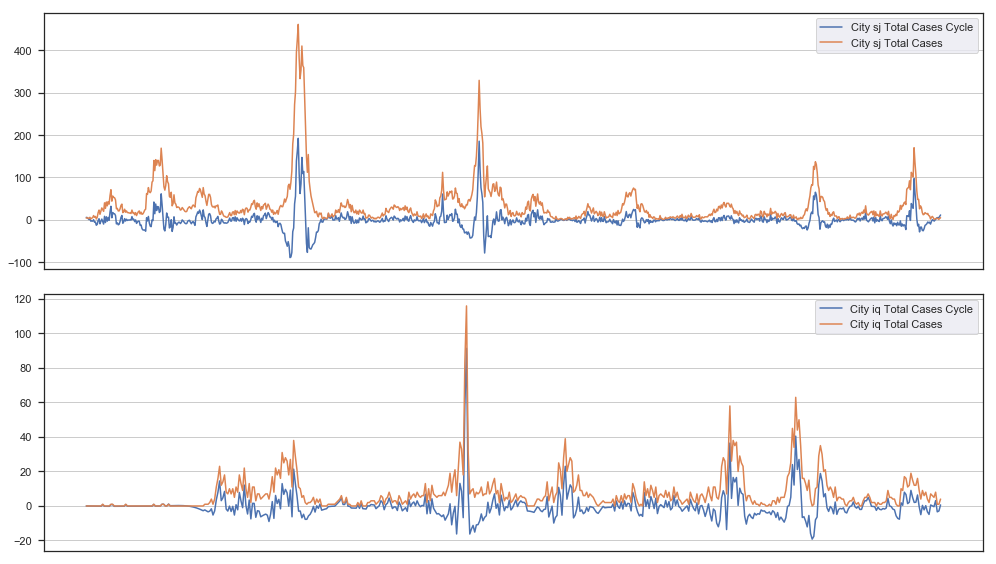

In [5]:
from statsmodels.api import tsa

sj_y_cycle, sj_y_trend = tsa.filters.hpfilter(sj_y)
iq_y_cycle, iq_y_trend = tsa.filters.hpfilter(iq_y)

rcParams['figure.figsize'] = 14, 8
fig, ax = plt.subplots(2,1)
sns.set()

ax[0].plot(sj_y_cycle, label='City sj Total Cases Cycle')
# ax[0].plot(sj_y_trend, label='City sj Total Cases Trend')
ax[0].plot(sj_y, label='City sj Total Cases')
ax[0].set_xticks([])
ax[0].legend()
ax[0].grid(True)

ax[1].plot(iq_y_cycle, label='City iq Total Cases Cycle')
# ax[1].plot(iq_y_trend, label='City iq Total Cases Trend')
ax[1].plot(iq_y, label='City iq Total Cases')
ax[1].set_xticks([])
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show();

__Simple Moiving Averages: Let's create some moving averages as well__

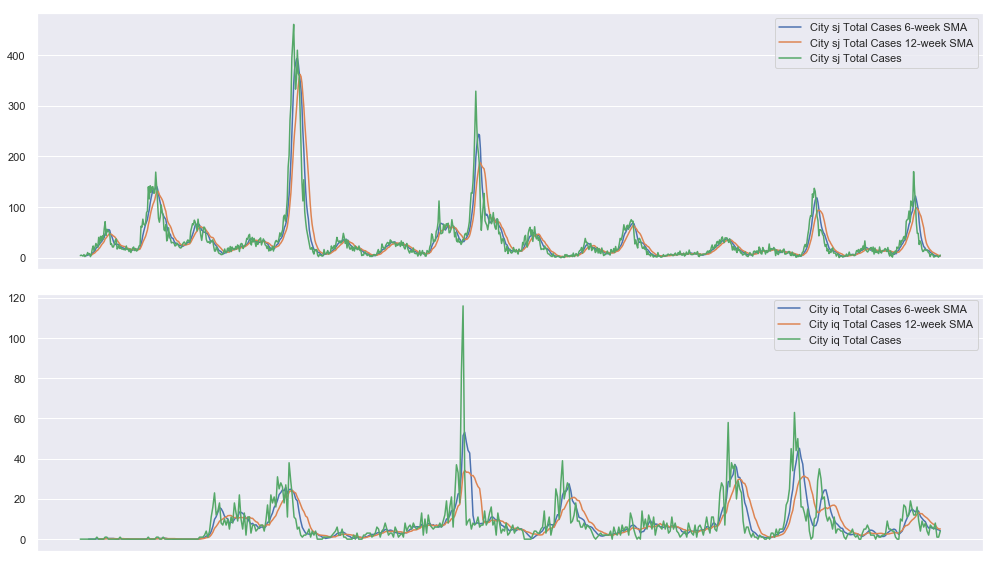

In [6]:
# 6 Period moving averages
sj_y_6_period_sma = sj_y.rolling(window=6).mean()
iq_y_6_period_sma = iq_y.rolling(window=6).mean()

# 12 Period moving averages
sj_y_12_period_sma = sj_y.rolling(window=12).mean()
iq_y_12_period_sma = iq_y.rolling(window=12).mean()

rcParams['figure.figsize'] = 14, 8
fig, ax = plt.subplots(2,1)
sns.set()

ax[0].plot(sj_y_6_period_sma, label='City sj Total Cases 6-week SMA')
ax[0].plot(sj_y_12_period_sma, label='City sj Total Cases 12-week SMA')
ax[0].plot(sj_y, label='City sj Total Cases')
ax[0].set_xticks([])
ax[0].legend()
ax[0].grid(True)

ax[1].plot(iq_y_6_period_sma, label='City iq Total Cases 6-week SMA')
ax[1].plot(iq_y_12_period_sma, label='City iq Total Cases 12-week SMA')
ax[1].plot(iq_y, label='City iq Total Cases')
ax[1].set_xticks([])
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()
plt.show();

__Exponentially Weighted Moving Averages: Since our plots don't reveal a consistent trend of the total number of dengue cases of both cities with time, we will not calculate any exponentially weighted moving averages.__

__Error, Trend, and Seasonality: Let's use statsmodel's `seasonal_decompose` api to see if there's other information with can still extract from the total number of cases__

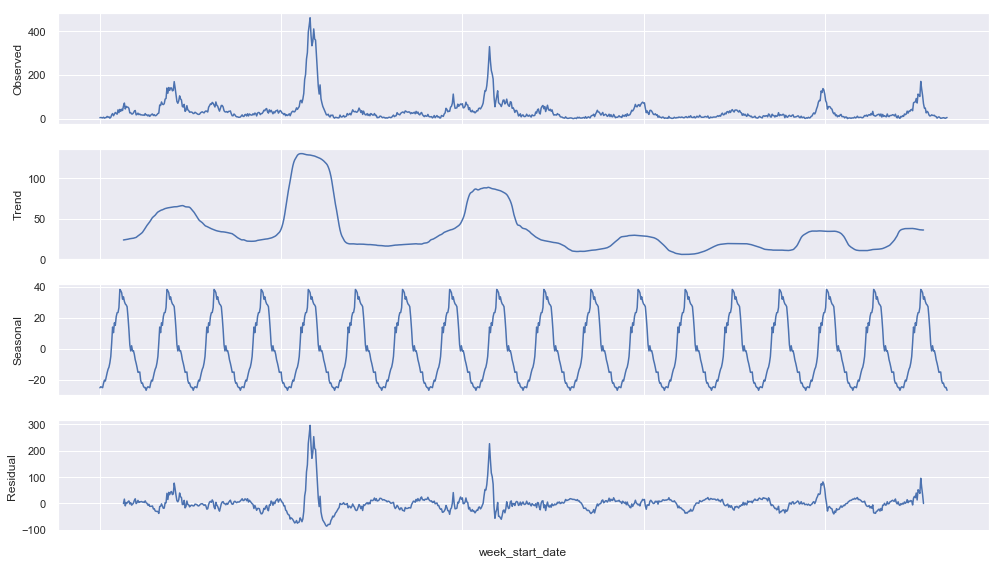

In [7]:
sj_ets = tsa.seasonal_decompose(sj_y, model='additive', freq=52).plot()

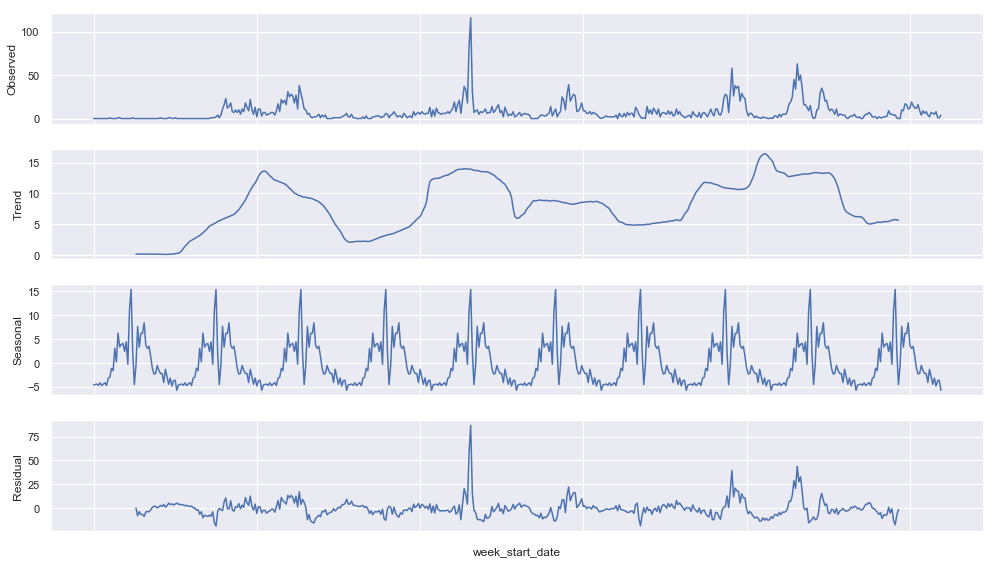

In [8]:
iq_ets = tsa.seasonal_decompose(iq_y, model='additive', freq=52).plot()

---
<a id="arima"></a>

## ARIMA

### Testing for Stationarity

__Here we will use the Augmented Dickey-Fuller Test to test whether our labels are indeed stationary in order to  be  used for ARIMA__

__Let's take a quick look again at the labels for each city, and also the first difference__

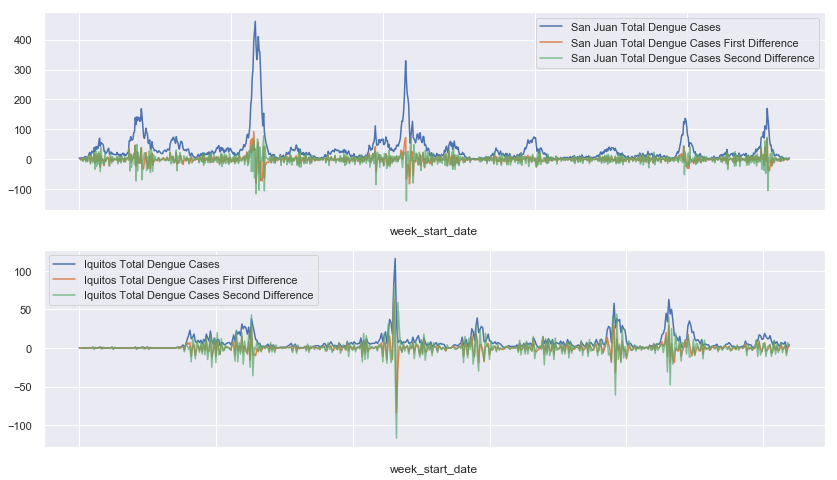

In [9]:
fig, ax = plt.subplots(2,1)
rcParams['figure.figsize'] = 14, 16

sj_y['num_cases'].plot(ax=ax[0], label='San Juan Total Dengue Cases', grid=True, legend=True);
(sj_y - sj_y.shift(1))['num_cases'].plot(ax=ax[0], label='San Juan Total Dengue Cases First Difference', grid=True, legend=True)
((sj_y - sj_y.shift(1)) - (sj_y - sj_y.shift(1)).shift(1))['num_cases'].plot(ax=ax[0], label='San Juan Total Dengue Cases Second Difference', grid=True, legend=True, alpha=0.7)

iq_y['num_cases'].plot(ax=ax[1], label='Iquitos Total Dengue Cases', grid=True, legend=True);
(iq_y - iq_y.shift(1))['num_cases'].plot(ax=ax[1], label='Iquitos Total Dengue Cases First Difference', grid=True, legend=True)
((iq_y - iq_y.shift(1)) - (iq_y - iq_y.shift(1)).shift(1))['num_cases'].plot(ax=ax[1], label='Iquitos Total Dengue Cases Second Difference', grid=True, legend=True, alpha=0.7)

plt.show();

In [10]:
from statsmodels.tsa.stattools import adfuller

# Store in a function for later use!
def adf_check(time_series):
    """
    Pass in a time series, returns ADF report
    """
    result = adfuller(time_series)
    print('Augmented Dickey-Fuller Test:')
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']

    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    
    if result[1] <= 0.01:
        print("Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [11]:
adf_check(sj_y['num_cases'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.650077901931188
p-value : 5.1473186737592894e-09
#Lags Used : 9
Number of Observations Used : 926
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [12]:
adf_check((sj_y - sj_y.shift(1))['num_cases'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -10.227970545594637
p-value : 5.117134120459222e-18
#Lags Used : 12
Number of Observations Used : 922
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [13]:
adf_check(iq_y['num_cases'])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.085428681900057
p-value : 1.0672522948401663e-07
#Lags Used : 4
Number of Observations Used : 515
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [14]:
adf_check((iq_y - iq_y.shift(1))['num_cases'].dropna())

Augmented Dickey-Fuller Test:
ADF Test Statistic : -11.682119354999621
p-value : 1.7313438978739138e-21
#Lags Used : 5
Number of Observations Used : 513
Strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


__Looks like our labels are already stationary, even before first differencing, now let's take a look at the Autocorrelation and Partial Autocorrelation plots to determine if we should use an Autoregressive or Moving Average model.__

---
## Autocorrelation and Partial Autocorrelation Plots

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

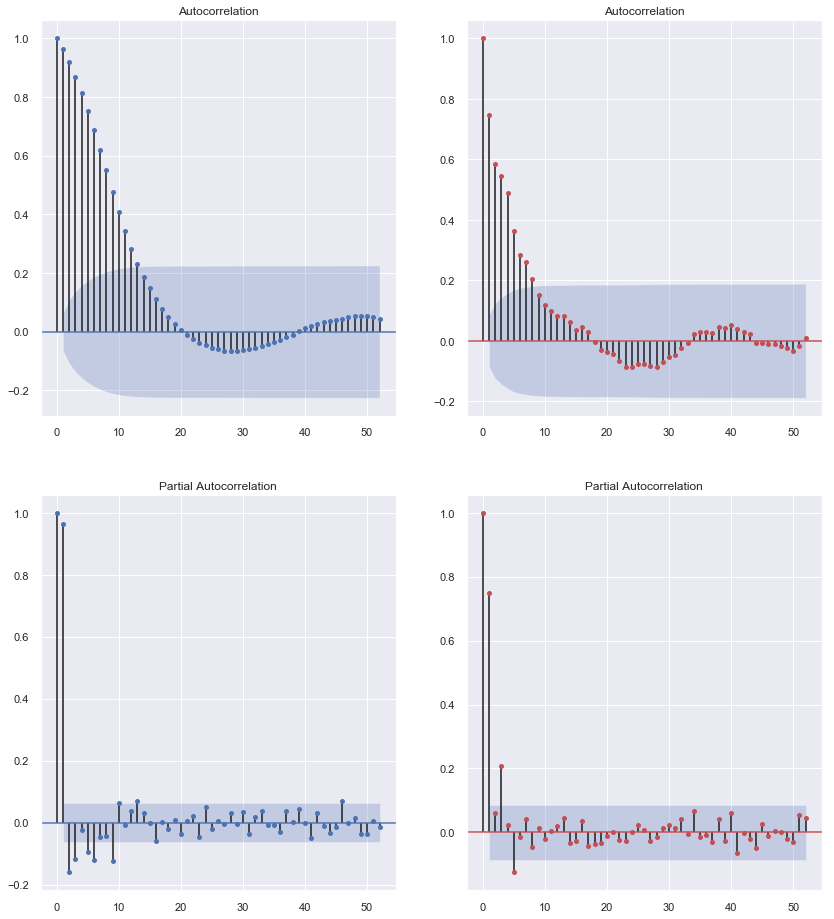

In [16]:
fig, ax = plt.subplots(2,2)
rcParams['figure.figsize'] = 16, 16

sj_acf = plot_acf(sj_y['num_cases'], ax=ax[0,0], lags=52)
sj_pacf = plot_pacf(sj_y['num_cases'], ax=ax[1,0], lags=52)

iq_acf = plot_acf(iq_y['num_cases'], ax=ax[0,1], color='r', lags=52)
iq_pacf = plot_pacf(iq_y['num_cases'], ax=ax[1,1], color='r', lags=52)

plt.show();

---
## Seasonal AutoRegressive Integrated Moving Average with Exogenous Features (SARIMAX)

In [17]:
test_dates = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')['city']
sj_y = pd.concat([sj_y, pd.DataFrame(index=test_dates[test_dates == 'sj'].index, columns=['num_cases'])], axis=0)
iq_y = pd.concat([iq_y, pd.DataFrame(index=test_dates[test_dates == 'iq'].index, columns=['num_cases'])], axis=0)

In [18]:
sj_X_train = pd.read_csv('./data/dengai/cleaned/sj_X.csv', index_col=[0])
iq_X_train = pd.read_csv('./data/dengai/cleaned/iq_X.csv', index_col=[0])

# Clean Test Features
test_feats_df = pd.read_csv('./data/dengai/test_features/dengue_features_test.csv', index_col='week_start_date')

# Taking care of missing data
test_feats_df.fillna(test_feats_df.mode().iloc[0], inplace=True)

# Drop unecessary feature columns
test_feats_df = test_feats_df.drop(['year', 'weekofyear'], axis=1)

# Split dataset to City sj and City iq
sj_X_test = test_feats_df[test_feats_df['city'] == 'sj'].drop(['city'], axis=1)
iq_X_test = test_feats_df[test_feats_df['city'] == 'iq'].drop(['city'], axis=1)

In [28]:
def get_best_sarimax_start(results, y, X=None, min_samples=50, max_samples=None):
    """
    ============
    = FUNCTION =
    ============
    Function to find the best number of samples to 
    use SARIMAX to predict on to get lowest MAE
    
    ==============
    = PARAMETERS =
    ==============
    results: MLE Estimate of SARIMAX
    y: DataFrame of the total dengue cases
    X: DataFrame with exogenous features required for our SARIMAX
    min_samples: The minimum number of samples used to make a prediction on
    max_samples: The maximum number of samples used to make a prediction on
    
    ===========
    = RETURNS =
    ===========
    predictions: The dictionary of DataFrames containing the predictions of total number of dengue cases
    residuals: The dicitionary of Series containing the residuals between predictions and ground truth values of total dengue cases
    best_start: The most optimal location to start the prediction in order to eliminate seasonality and get lowest MAE
    maes: The dictionary of mae scores for each starting point
    
    """
    # Parameters we tuned to get the best model for City predictions
    best_start = 0
    best_mae = sys.maxsize
    predictions = {start: None for start in range(min_samples, max_samples)}
    residuals = {start: None for start in range(min_samples, max_samples)}
    maes = {start: None for start in range(min_samples, max_samples)}

    # Loop through all the possible training samples we can train on
    for start in tqdm(range(min_samples, max_samples)):
        
        # Predict for City 
        if X:
            predictions[start] = pd.DataFrame(
                [np.nan for i in range(start)] +
                list(map(int, results.predict(
                    start=start,
                    end=len(y['num_cases']) - 1,
                    exog=X.loc[y['num_cases'].last_valid_index():].iloc[1:], # Exogenous Features from Out of Sample forecast onwards
                    dynamic=True))), 
                index=y['num_cases'].index,
                columns=['num_cases'])
        else:
            predictions[start] = pd.DataFrame(
                [np.nan for i in range(start)] +
                list(map(int, results.predict(
                    start=start,
                    end=len(y['num_cases']) - 1,
                    dynamic=True))), 
                index=y['num_cases'].index,
                columns=['num_cases'])
        
        # Get Training Data Residuals
        residuals[start] = y['num_cases'].loc[y.iloc[start].name:y['num_cases'].last_valid_index()] - predictions[start]['num_cases'].loc[y.iloc[start].name:y['num_cases'].last_valid_index()]
        mae = np.sum(np.abs(residuals[start])) / len(residuals[start])
        maes[start] = mae
        
        if mae < best_mae:
            best_start = start
            best_mae = mae
    
    print('Best Number of Training Samples: {}'.format(best_start))
    print('Best MAE on Training Data: {}'.format(best_mae))
    
    return predictions, residuals, maes, best_start

In [20]:
sj_mod = sm.tsa.statespace.SARIMAX(endog=np.asarray(sj_y['num_cases'][:sj_y['num_cases'].last_valid_index()].astype(int)), 
                                   exog=sj_X_train,
                                   trend='n', 
                                   order=(0,0,0), 
                                   seasonal_order=(1,1,1,52))
sj_results = sj_mod.fit()
print(sj_results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  936
Model:             SARIMAX(1, 1, 1, 52)   Log Likelihood               -4698.768
Date:                  Thu, 18 Apr 2019   AIC                           9443.535
Time:                          23:22:34   BIC                           9553.578
Sample:                               0   HQIC                          9485.609
                                  - 936                                         
Covariance Type:                    opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                  -9.6985     29.754     -0.326      0.744     -68.015      48.618
ndvi_nw                           

100%|██████████| 350/350 [01:46<00:00,  2.86it/s]


Best Number of Training Samples: 397
Best MAE on Training Data: 27.771799628942485


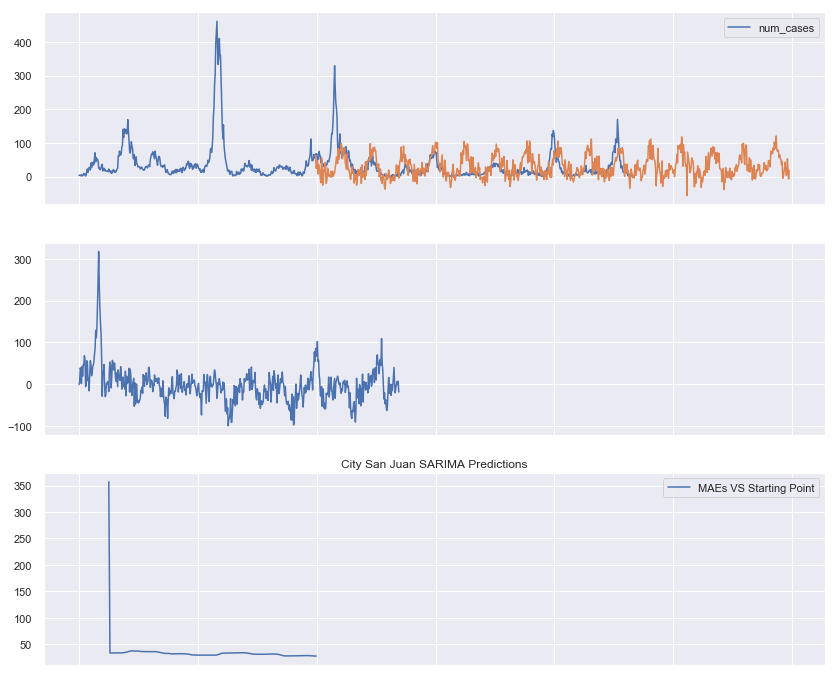

In [21]:
# Get Best Model
sj_pred, sj_resid, sj_maes, sj_best_start = get_best_sarimax_start(sj_results, sj_y, pd.concat([sj_X_train, sj_X_test], axis=0), min_samples=50, max_samples=400)

# Plot the Predictions against Original
sns.set()
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
sj_y[['num_cases']].plot(ax=ax[0])
sj_pred[sj_best_start]['num_cases'].plot(ax=ax[0], label="Total Predicted Number of Dengue Cases")
sj_resid[sj_best_start].plot(ax=ax[1])
ax[2].plot(sj_maes.keys(), sj_maes.values(), label="MAEs VS Starting Point")

plt.title('City San Juan SARIMA Predictions')
plt.legend()
plt.show();

In [22]:
iq_mod = sm.tsa.statespace.SARIMAX(endog=np.asarray(iq_y['num_cases'][:iq_y['num_cases'].last_valid_index()].astype(int)),
                                   exog=iq_X_train,
                                   trend='n',
                                   order=(0,0,0),
                                   seasonal_order=(1,1,1,52))
iq_results = iq_mod.fit()
print(iq_results.summary())

                            Statespace Model Results                            
Dep. Variable:                        y   No. Observations:                  520
Model:             SARIMAX(1, 1, 1, 52)   Log Likelihood               -1802.236
Date:                  Thu, 18 Apr 2019   AIC                           3650.472
Time:                          23:26:24   BIC                           3745.887
Sample:                               0   HQIC                          3688.018
                                  - 520                                         
Covariance Type:                    opg                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
ndvi_ne                                   3.0058     16.249      0.185      0.853     -28.841      34.853
ndvi_nw                           

100%|██████████| 200/200 [00:36<00:00,  5.50it/s]


Best Number of Training Samples: 131
Best MAE on Training Data: 6.745501285347044


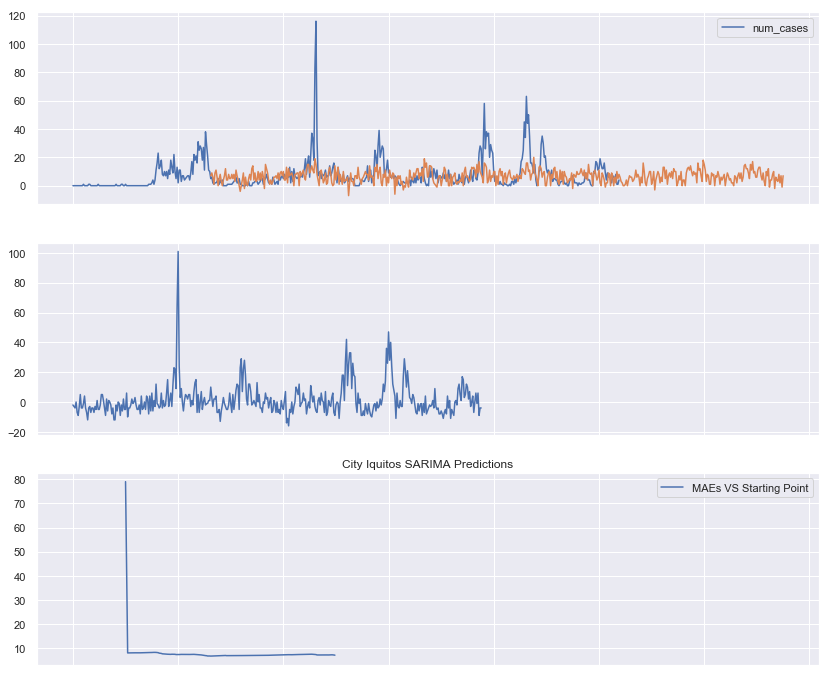

In [23]:
# Get Best Model
iq_pred, iq_resid, iq_maes, iq_best_start = get_best_sarimax_start(iq_results, iq_y, pd.concat([iq_X_train, iq_X_test], axis=0), min_samples=50, max_samples=250)

# Plot the Predictions against Original
sns.set()
fig, ax = plt.subplots(3, 1, figsize=(14, 12), sharex=True)
iq_y[['num_cases']].plot(ax=ax[0])
iq_pred[iq_best_start]['num_cases'].plot(ax=ax[0], label="Total Predicted Number of Dengue Cases")
iq_resid[iq_best_start].plot(ax=ax[1])
ax[2].plot(iq_maes.keys(), iq_maes.values(), label="MAEs VS Starting Point")

plt.title('City Iquitos SARIMA Predictions')
plt.legend()
plt.show();

In [25]:
# Save the results to csv and upload to competition
submission_df = pd.read_csv('./data/dengai/submission_format.csv')

# City SJ
sj_submission_df = submission_df[submission_df['city'] == 'sj'].drop(['total_cases'], axis=1)
sj_submission_df.reset_index(inplace=True)
sj_submission_df = pd.concat([sj_submission_df, 
                              pd.DataFrame(sj_pred[sj_best_start].loc[test_dates[test_dates == 'sj'].index]['num_cases'].values.flatten().astype(int),
                                           columns=['total_cases'])], 
                             axis=1)
sj_submission_df.index = sj_submission_df['index']
sj_submission_df.drop(['index'], axis=1, inplace=True)

# City IQ
iq_submission_df = submission_df[submission_df['city'] == 'iq'].drop(['total_cases'], axis=1)
iq_submission_df.reset_index(inplace=True)
iq_submission_df = pd.concat([iq_submission_df, 
                              pd.DataFrame(iq_pred[iq_best_start].loc[test_dates[test_dates == 'iq'].index]['num_cases'].values.flatten().astype(int), 
                                           columns=['total_cases'])], 
                             axis=1)
iq_submission_df.index = iq_submission_df['index']
iq_submission_df.drop(['index'], axis=1, inplace=True)

submission_df = pd.concat([sj_submission_df, iq_submission_df], axis=0).reset_index().drop(['index'], axis=1)
submission_df.head()

,city,year,weekofyear,total_cases
0,sj,2008,18,36
1,sj,2008,19,4
2,sj,2008,20,15
3,sj,2008,21,43
4,sj,2008,22,49


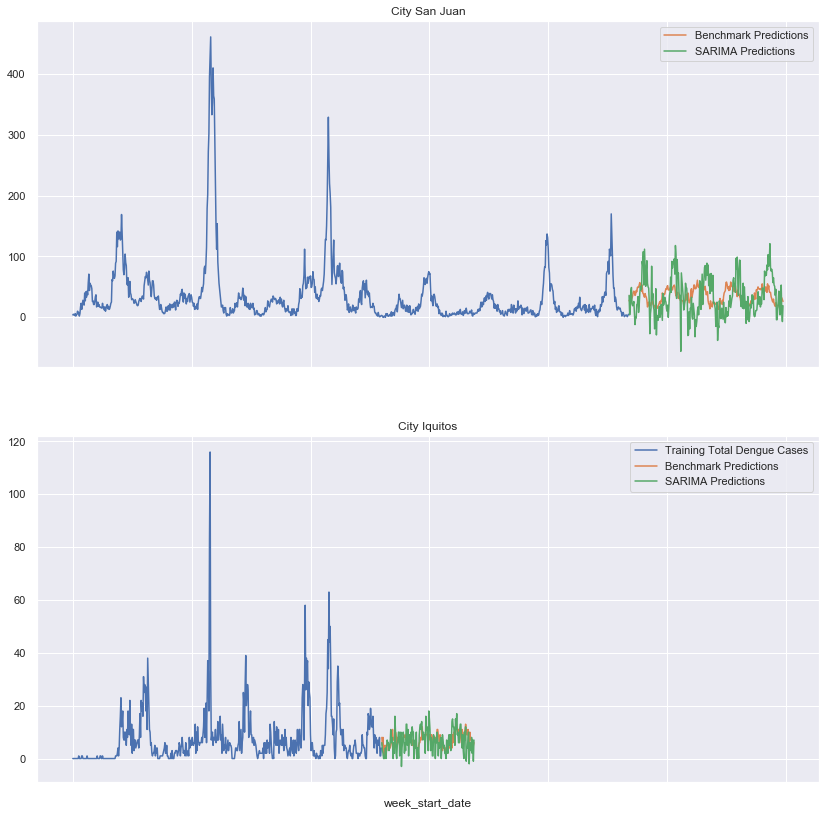

In [26]:
# Benchmark Predictions
benchmark = pd.read_csv('./data/dengai/benchmark.csv')

sj_bench = benchmark[benchmark['city'] == 'sj']['total_cases']
sj_bench = pd.DataFrame([np.nan for i in range(len(sj_y.loc[:sj_y.last_valid_index()]))] + list(sj_bench.values),
                         index=sj_y.index,
                         columns=['Benchmark Predictions'])

iq_bench = benchmark[benchmark['city'] == 'iq']['total_cases']
iq_bench = pd.DataFrame([np.nan for i in range(len(iq_y.loc[:iq_y.last_valid_index()]))] + list(iq_bench.values),
                         index=iq_y.index,
                         columns=['Benchmark Predictions'])

# SARIMA Predictions
sj_sarima = sj_pred[sj_best_start].loc[test_dates[test_dates == 'sj'].index]['num_cases']
sj_sarima = pd.DataFrame([np.nan for i in range(len(sj_y.loc[:sj_y.last_valid_index()]))] + list(sj_sarima.values),
                         index=sj_y.index,
                         columns=['SARIMA Predictions'])

iq_sarima = iq_pred[iq_best_start].loc[test_dates[test_dates == 'iq'].index]['num_cases']
iq_sarima = pd.DataFrame([np.nan for i in range(len(iq_y.loc[:iq_y.last_valid_index()]))] + list(iq_sarima.values),
                         index=iq_y.index,
                         columns=['SARIMA Predictions'])

# Plot 
sns.set()
fig, ax = plt.subplots(2, 1, figsize=(14, 14), sharex=True)

ax[0].set_title("City San Juan")
ax[0].plot(sj_y[['num_cases']].values, label="Training Total Dengue Cases")
sj_bench.plot(ax=ax[0])
sj_sarima.plot(ax=ax[0])

ax[1].set_title("City Iquitos")
ax[1].plot(iq_y[['num_cases']].values, label="Training Total Dengue Cases")
iq_bench.plot(ax=ax[1])
iq_sarima.plot(ax=ax[1])

plt.legend()
plt.show();

In [27]:
# Save to csv
submission_df.to_csv('./data/dengai/sarimax_submission.csv', index=False)

__Submission MAE: 29.9663__